# Самостоятельный проект: Обучение с учителем - Качество модели

## Описание проекта

Интернет-магазин **«В один клик»** предлагает широкий ассортимент товаров: от товаров для детей до косметики и продуктов. Анализ показал, что активность постоянных клиентов снижается, и привлекать новых клиентов становится менее эффективным. Руководство приняло решение ориентироваться на удержание постоянных клиентов с использованием персонализированных предложений.

Компания «В один клик» является современной, и решение об удержании клиентов принимается на основе анализа данных и бизнес-моделирования. Ваш отдел цифровых технологий получил задачу разработать решение, которое позволит персонализировать предложения для постоянных клиентов и, таким образом, увеличить их покупательскую активность.

## Задачи проекта

1. **Маркировка уровня финансовой активности:**
   - Определение уровня активности клиентов: «снизилась» или «прежний уровень».

2. **Сбор данных:**
   - Собрать данные по клиентам в следующих группах:
      - Коммуникация сотрудников компании с клиентом.
      - Продуктовое поведение покупателя.
      - Покупательское поведение клиента.
      - Поведение покупателя на сайте.

3. **Визуализация данных:**
   - Визуализировать данные.

4. **Построение модели:**
   - Разработать модель, предсказывающую вероятность снижения покупательской активности в следующие три месяца.

5. **Интеграция данных о прибыли:**
   - Включить данные финансового департамента о прибыльности клиента за последние три месяца.

6. **Сегментация клиентов и персонализированные предложения:**
   - Выделить сегменты клиентов и разработать для них персонализированные предложения.

7. **Оценка и оптимизация:**
   - Оценить эффективность персонализированных предложений и провести оптимизацию стратегий при необходимости.

## Данные для работы

Данные предоставлены в нескольких таблицах:
- **market_file.csv:** информация о поведении покупателя на сайте, коммуникациях и продуктовом поведении.
- **market_money.csv:** данные о выручке, полученной от покупателя.
- **market_time.csv:** информация о времени, проведенном покупателем на сайте.
- **money.csv:** данные о среднемесячной прибыли покупателя за последние 3 месяца.


# Импортируемые библиотеки

In [1]:
!pip install phik shap category_encoders -q

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import category_encoders as ce

from sklearn.metrics import f1_score

# Шаг 1. Загрузка данных


In [3]:
market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';')

### market_file.csv


In [4]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [5]:
# Проверка на наличие дубликатов
duplicates = market_file[market_file.duplicated(keep=False)]
if not duplicates.empty:
    print("Обнаружены дубликаты данных:")
    display(duplicates)
else:
    print("Дубликатов данных не найдено.")

Дубликатов данных не найдено.


In [6]:
# Проверка на наличие пропусков
missing_values = market_file.isnull().sum()
if missing_values.sum() > 0:
    print("Обнаружены пропуски данных:")
    print(missing_values)
else:
    print("Пропусков данных не найдено.")

Пропусков данных не найдено.


In [7]:
# Общая информация о DataFrame
print("Общая информация о DataFrame:")
print(market_file.info())

Общая информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  

In [8]:
# Описание количественных данных
print("Описание количественных данных:")
display(market_file.describe())

Описание количественных данных:


,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [9]:
# Описание категориальных данных
categorical_columns = market_file.select_dtypes(include=['object']).columns
if not categorical_columns.empty:
    print("Описание категориальных данных:")
    display(market_file[categorical_columns].describe())
else:
    print("Категориальных данных в DataFrame не найдено.")

Описание категориальных данных:


,Покупательская активность,Тип сервиса,Разрешить сообщать,Популярная_категория
count,1300,1300,1300,1300
unique,2,3,2,6
top,Прежний уровень,стандарт,да,Товары для детей
freq,802,914,962,330


In [10]:
# Распределение значений в категориальных признаках
for column in categorical_columns:
    print(f"Распределение значений в {column}:")
    display(market_file[column].value_counts())

Распределение значений в Покупательская активность:


Прежний уровень    802
Снизилась          498
Name: Покупательская активность, dtype: int64

Распределение значений в Тип сервиса:


стандарт     914
премиум      376
стандартт     10
Name: Тип сервиса, dtype: int64

Распределение значений в Разрешить сообщать:


да     962
нет    338
Name: Разрешить сообщать, dtype: int64

Распределение значений в Популярная_категория:


Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64

In [11]:
# Распределение значений в категориальных признаках
for column in categorical_columns:
    print(f"Распределение значений в {column}:")
    display(market_file[column].value_counts())

Распределение значений в Покупательская активность:


Прежний уровень    802
Снизилась          498
Name: Покупательская активность, dtype: int64

Распределение значений в Тип сервиса:


стандарт     914
премиум      376
стандартт     10
Name: Тип сервиса, dtype: int64

Распределение значений в Разрешить сообщать:


да     962
нет    338
Name: Разрешить сообщать, dtype: int64

Распределение значений в Популярная_категория:


Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: Популярная_категория, dtype: int64

In [12]:
# Корреляция между признаками с использованием phik
print("Корреляция между признаками (phik):")
phik_matrix = market_file.phik_matrix()

Корреляция между признаками (phik):
interval columns not set, guessing: ['id', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит']


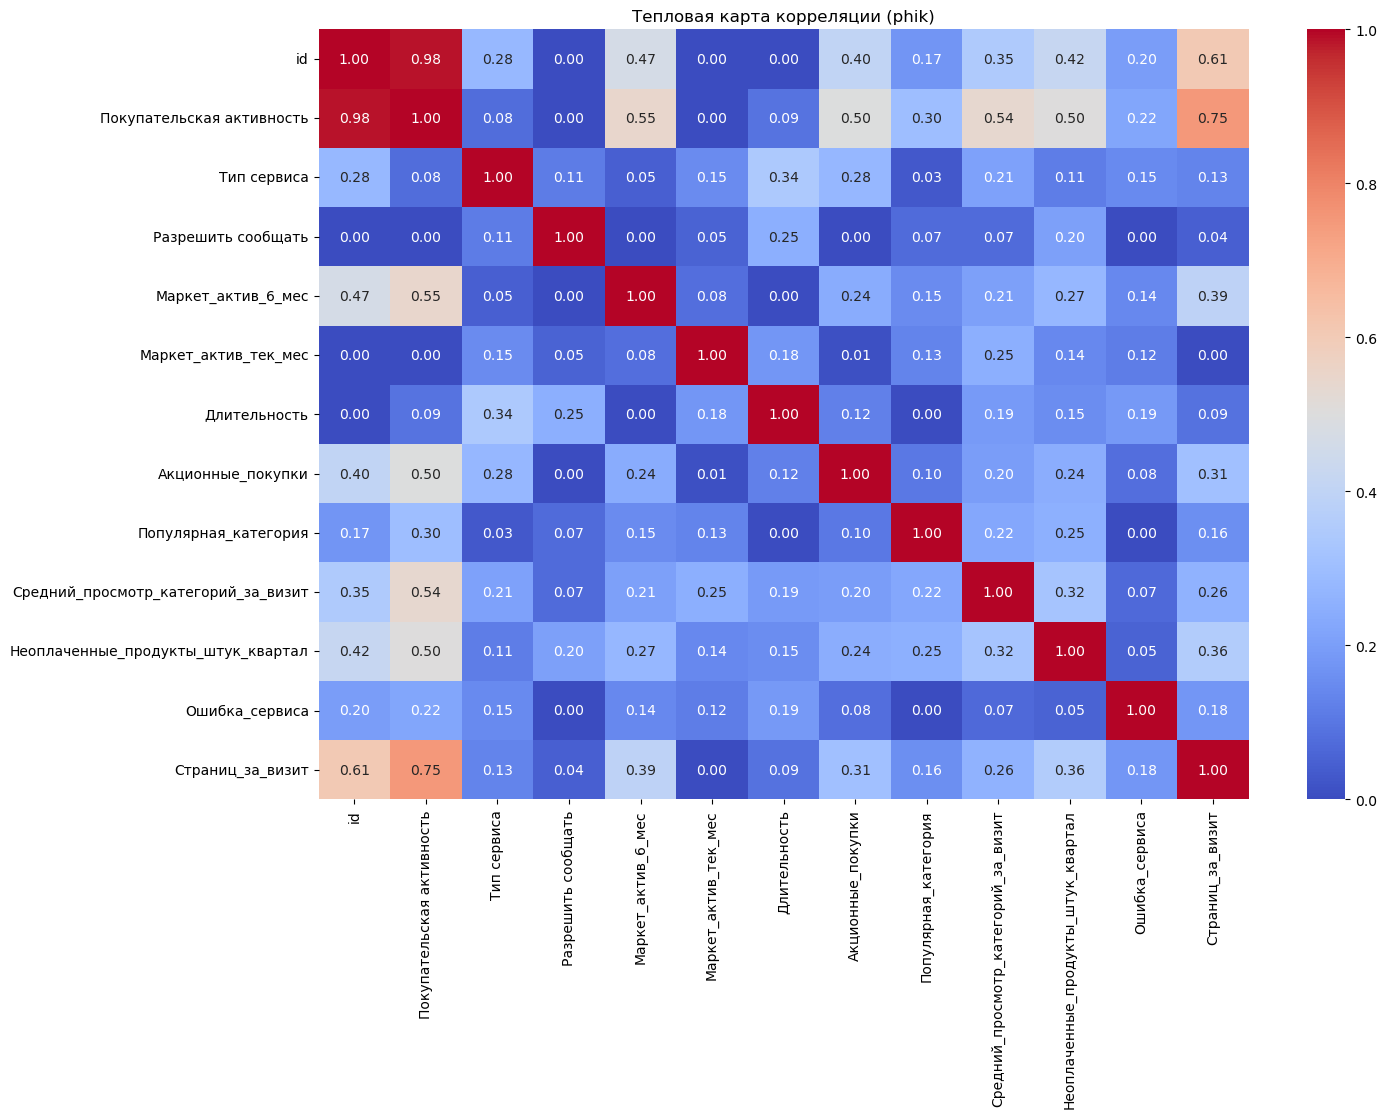

In [13]:
# Визуализация корреляции (пример)
plt.figure(figsize=(15, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляции (phik)')
plt.show()

In [14]:
# Вывод уникальных пар с сильной корреляцией и их силы
strong_corr_threshold = 0.8
strong_corr_pairs = set()

In [15]:
for i, col in enumerate(phik_matrix.columns):
    correlated_cols = phik_matrix.index[i+1:][phik_matrix[col][i+1:] > strong_corr_threshold].tolist()
    for correlated_col in correlated_cols:
        pair = (col, correlated_col)
        correlation_strength = phik_matrix.at[correlated_col, col]
        strong_corr_pairs.add((pair, correlation_strength))

In [16]:
if strong_corr_pairs:
    print("Пары с сильной корреляцией и их сила:")
    for pair, strength in strong_corr_pairs:
        print(f"{pair}: {strength:.2f}")
else:
    print("Сильной корреляции в датасете не найдено.")

Пары с сильной корреляцией и их сила:
('id', 'Покупательская активность'): 0.98


### market_money.csv


In [17]:
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [18]:
# Проверка на наличие дубликатов
duplicates = market_money[market_money.duplicated(keep=False)]
if not duplicates.empty:
    print("Обнаружены дубликаты данных:")
    display(duplicates)
else:
    print("Дубликатов данных не найдено.")

Дубликатов данных не найдено.


In [19]:
# Проверка на наличие пропусков
missing_values = market_money.isnull().sum()
if missing_values.sum() > 0:
    print("Обнаружены пропуски данных:")
    print(missing_values)
else:
    print("Пропусков данных не найдено.")

Пропусков данных не найдено.


In [20]:
# Общая информация о DataFrame
print("Общая информация о DataFrame:")
print(market_money.info())

Общая информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


In [21]:
# Описание количественных данных
print("Описание количественных данных:")
display(market_money.describe())

Описание количественных данных:


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


In [22]:
# Описание категориальных данных
categorical_columns = market_money.select_dtypes(include=['object']).columns
if not categorical_columns.empty:
    print("Описание категориальных данных:")
    display(market_money[categorical_columns].describe())
else:
    print("Категориальных данных в DataFrame не найдено.")

Описание категориальных данных:


,Период
count,3900
unique,3
top,препредыдущий_месяц
freq,1300


In [23]:
# Распределение значений в категориальных признаках
for column in categorical_columns:
    print(f"Распределение значений в {column}:")
    display(market_money[column].value_counts())

Распределение значений в Период:


препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: Период, dtype: int64

In [24]:
# Распределение значений в категориальных признаках
for column in categorical_columns:
    print(f"Распределение значений в {column}:")
    display(market_money[column].value_counts())

Распределение значений в Период:


препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: Период, dtype: int64

In [25]:
#  Корреляция между признаками с использованием phik
print("Корреляция между признаками (phik):")
phik_matrix = market_money.phik_matrix()

Корреляция между признаками (phik):
interval columns not set, guessing: ['id', 'Выручка']


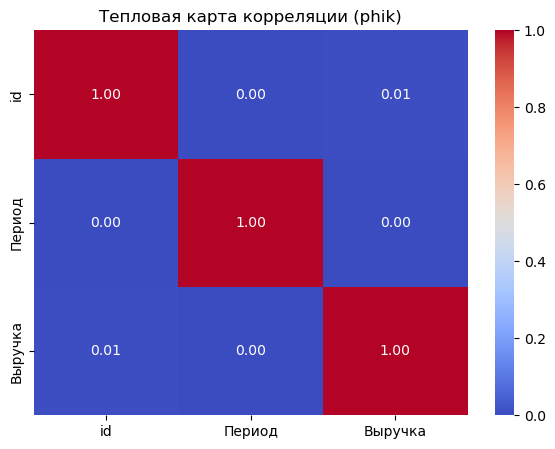

In [26]:
# Визуализация корреляции (пример)
plt.figure(figsize=(7, 5))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляции (phik)')
plt.show()

In [27]:
# Вывод уникальных пар с сильной корреляцией и их силы
strong_corr_threshold = 0.8
strong_corr_pairs = set()

In [28]:
for i, col in enumerate(phik_matrix.columns):
    correlated_cols = phik_matrix.index[i+1:][phik_matrix[col][i+1:] > strong_corr_threshold].tolist()
    for correlated_col in correlated_cols:
        pair = (col, correlated_col)
        correlation_strength = phik_matrix.at[correlated_col, col]
        strong_corr_pairs.add((pair, correlation_strength))

In [29]:
if strong_corr_pairs:
    print("Пары с сильной корреляцией и их сила:")
    for pair, strength in strong_corr_pairs:
        print(f"{pair}: {strength:.2f}")
else:
    print("Сильной корреляции в датасете не найдено.")

Сильной корреляции в датасете не найдено.


### market_time.csv


In [30]:
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [31]:
# Проверка на наличие дубликатов
duplicates = market_time[market_time.duplicated(keep=False)]
if not duplicates.empty:
    print("Обнаружены дубликаты данных:")
    display(duplicates)
else:
    print("Дубликатов данных не найдено.")

Дубликатов данных не найдено.


In [32]:
# Проверка на наличие пропусков
missing_values = market_time.isnull().sum()
if missing_values.sum() > 0:
    print("Обнаружены пропуски данных:")
    print(missing_values)
else:
    print("Пропусков данных не найдено.")

Пропусков данных не найдено.


In [33]:
# Общая информация о DataFrame
print("Общая информация о DataFrame:")
print(market_time.info())

Общая информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


In [34]:
# Описание количественных данных
print("Описание количественных данных:")
display(market_time.describe())

Описание количественных данных:


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


In [35]:
# Описание категориальных данных
categorical_columns = market_time.select_dtypes(include=['object']).columns
if not categorical_columns.empty:
    print("Описание категориальных данных:")
    display(market_time[categorical_columns].describe())
else:
    print("Категориальных данных в DataFrame не найдено.")

Описание категориальных данных:


,Период
count,2600
unique,2
top,текущий_месяц
freq,1300


In [36]:
# Распределение значений в категориальных признаках
for column in categorical_columns:
    print(f"Распределение значений в {column}:")
    display(market_time[column].value_counts())

Распределение значений в Период:


текущий_месяц       1300
предыдцщий_месяц    1300
Name: Период, dtype: int64

In [37]:
# Распределение значений в категориальных признаках
for column in categorical_columns:
    print(f"Распределение значений в {column}:")
    display(market_time[column].value_counts())

Распределение значений в Период:


текущий_месяц       1300
предыдцщий_месяц    1300
Name: Период, dtype: int64

In [38]:
# Корреляция между признаками с использованием phik
print("Корреляция между признаками (phik):")
phik_matrix = market_time.phik_matrix()

Корреляция между признаками (phik):
interval columns not set, guessing: ['id', 'минут']


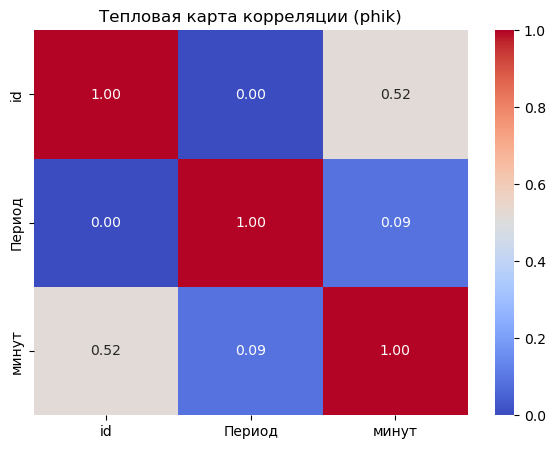

In [39]:
# Визуализация корреляции
plt.figure(figsize=(7, 5))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляции (phik)')
plt.show()

In [40]:
# Вывод уникальных пар с сильной корреляцией и их силы
strong_corr_threshold = 0.8
strong_corr_pairs = set()

In [41]:
for i, col in enumerate(phik_matrix.columns):
    correlated_cols = phik_matrix.index[i+1:][phik_matrix[col][i+1:] > strong_corr_threshold].tolist()
    for correlated_col in correlated_cols:
        pair = (col, correlated_col)
        correlation_strength = phik_matrix.at[correlated_col, col]
        strong_corr_pairs.add((pair, correlation_strength))

In [42]:
if strong_corr_pairs:
    print("Пары с сильной корреляцией и их сила:")
    for pair, strength in strong_corr_pairs:
        print(f"{pair}: {strength:.2f}")
else:
    print("Сильной корреляции в датасете не найдено.")

Сильной корреляции в датасете не найдено.


### money.csv


In [43]:
money.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


In [44]:
# Проверка на наличие дубликатов
duplicates = money[money.duplicated(keep=False)]
if not duplicates.empty:
    print("Обнаружены дубликаты данных:")
    display(duplicates)
else:
    print("Дубликатов данных не найдено.")

Дубликатов данных не найдено.


In [45]:
# Проверка на наличие пропусков
missing_values = money.isnull().sum()
if missing_values.sum() > 0:
    print("Обнаружены пропуски данных:")
    print(missing_values)
else:
    print("Пропусков данных не найдено.")

Пропусков данных не найдено.


In [46]:
# Общая информация о DataFrame
print("Общая информация о DataFrame:")
print(money.info())

Общая информация о DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB
None


In [47]:
# Описание количественных данных
print("Описание количественных данных:")
display(money.describe())

Описание количественных данных:


,id
count,1300.000000
mean,215997.500000
std,375.421985
min,215348.000000
25%,215672.750000
50%,215997.500000
75%,216322.250000
max,216647.000000


In [48]:
# Описание категориальных данных
categorical_columns = money.select_dtypes(include=['object']).columns
if not categorical_columns.empty:
    print("Описание категориальных данных:")
    display(money[categorical_columns].describe())
else:
    print("Категориальных данных в DataFrame не найдено.")

Описание категориальных данных:


,Прибыль
count,1300
unique,400
top,"3,89"
freq,11


In [49]:
# Распределение значений в категориальных признаках
for column in categorical_columns:
    print(f"Распределение значений в {column}:")
    display(money[column].value_counts())

Распределение значений в Прибыль:


3,89    11
4,18     9
4,28     9
5,1      9
4,33     8
        ..
2,63     1
2,61     1
1,37     1
1,55     1
6,11     1
Name: Прибыль, Length: 400, dtype: int64

In [50]:
# Распределение значений в категориальных признаках
for column in categorical_columns:
    print(f"Распределение значений в {column}:")
    display(money[column].value_counts())

Распределение значений в Прибыль:


3,89    11
4,18     9
4,28     9
5,1      9
4,33     8
        ..
2,63     1
2,61     1
1,37     1
1,55     1
6,11     1
Name: Прибыль, Length: 400, dtype: int64

In [51]:
# Корреляция между признаками с использованием phik
print("Корреляция между признаками (phik):")
phik_matrix = money.phik_matrix()

Корреляция между признаками (phik):
interval columns not set, guessing: ['id']


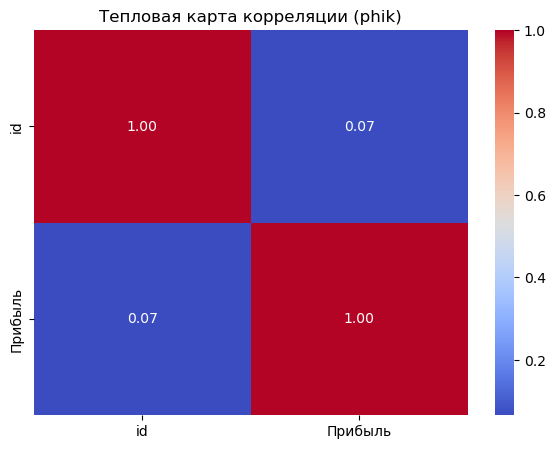

In [52]:
# Визуализация корреляции (пример)
plt.figure(figsize=(7, 5))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляции (phik)')
plt.show()

In [53]:
# Вывод уникальных пар с сильной корреляцией и их силы (задайте порог корреляции по вашему усмотрению)
strong_corr_threshold = 0.8
strong_corr_pairs = set()

In [54]:
for i, col in enumerate(phik_matrix.columns):
    correlated_cols = phik_matrix.index[i+1:][phik_matrix[col][i+1:] > strong_corr_threshold].tolist()
    for correlated_col in correlated_cols:
        pair = (col, correlated_col)
        correlation_strength = phik_matrix.at[correlated_col, col]
        strong_corr_pairs.add((pair, correlation_strength))

In [55]:
if strong_corr_pairs:
    print("Пары с сильной корреляцией и их сила:")
    for pair, strength in strong_corr_pairs:
        print(f"{pair}: {strength:.2f}")
else:
    print("Сильной корреляции в датасете не найдено.")

Сильной корреляции в датасете не найдено.


# Вывод:

**Данные содержатся в четырех файлах:** `market_file.csv`, `market_money.csv`, `market_time.csv`, `money.csv`

`Датафрейм (market_file)`:
Таблица, содержащая данные о поведении покупателя на сайте, коммуникациях с покупателем и его продуктовом поведении.

* датафрейм состоит из 1300 строк и 13 колонок;

* датафрейм содердит числовые и тексторые значения;

* Названия колонок указаны на русском языке, формат названия - "Название_колонки",  что в целом соответствует норме;

* Все колонки имеют нормальный тип данных

* В данных имеются опечатки в тексте которые необходимо исправить в процессе.



`Датафрейм (market_money)`: Эти данные позволяют оценить, сколько каждый покупатель потратил за определенный период взаимодействия с сайтом.

* Таблица состоит из 3900 строк и 3 колонки;
* содердит числовые и тексторые значения;
* В колонке "Выручка" необходимо поменять тип данных на (int).

`Датафрейм (market_time):` Таблица с данными о времени (в минутах), которое каждый покупатель провел на сайте в течение определенного периода.

* Таблица состоит из 2600 строк и 3 колонки;
* Колонки имеют правильный тип данных;
* Название колонки "минут" изменить на "Минут"

`Датафрейм (money):` Таблица с данными о среднемесячной прибыли, получаемой магазином от продаж каждого покупателя за последние 3 месяца.

* Таблица состоит из 1300 строк и 2 колонки;
* В столбце "Прибыль" необходимо поменять тип данных на (float)



# Шаг 2. Предобработка данных и исследовательский анализ


Подготовим функционал для формирования графиков:

In [56]:
# Функция для построения столбчатых диаграмм

def enhanced_bar_plot(df, column, rot=0):
    sns.set(style="whitegrid")

    balance_class = df[column].value_counts()
    x = balance_class.index
    y = balance_class.values

    # Используем цвета и добавляем обводку
    sns.barplot(x=x, y=y, palette='viridis', edgecolor='black')

    plt.title(f'Баланс классов {column}')
    plt.xlabel(column)
    plt.ylabel('Частота')

    # Увеличиваем размер шрифта
    for i in range(len(x)):
        plt.text(i, y[i] + 5, f'{y[i]}', fontsize=12, ha='center')

    # Сортируем значения на графике
    plt.xticks(rotation=rot, ha='right')
    plt.tight_layout()
    plt.show()

In [57]:
# Функция для формирования гистограммы и графика "Boxplot"

def plot_distribution_summary(df, column):
    if isinstance(column, str):
        column = [column]

    fig, axes = plt.subplots(2, 1, figsize=(15, 8))

    # Первый подграфик - гистограмма
    sns.histplot(data=df[column], kde=True, ax=axes[0])
    axes[0].grid()
    axes[0].set_title("Гистограмма")
    axes[0].set_xlabel(None)

    # Второй подграфик - настраиваемый boxplot
    sns.boxplot(data=df[column], palette='pastel', notch=True,
                linewidth=2, width=0.5, orient='horizontal', ax=axes[1])
    axes[1].set_title("Boxplot")
    axes[1].set_xlabel(None)

    # Добавление сетки на обоих подграфиках
    axes[0].grid(True)
    axes[1].grid(True)

    # Добавление медианы и среднего значения на график
    median = df[column].median()
    mean = df[column].mean()
    for i, col in enumerate(column):
        # Добавление медианы (черта и подпись)
        axes[1].axvline(median[col], color='red', linestyle='--', linewidth=2, label=f'Median ({col})')
        axes[1].text(median[col], i, f'Median: {median[col]:.2f}', va='top', ha='left', color='red')

        # Добавление среднего значения (черта и подпись)
        axes[1].axvline(mean[col], color='blue', linestyle='--', linewidth=2, label=f'Mean ({col})')
        axes[1].text(mean[col], i, f'Mean: {mean[col]:.2f}', va='bottom', ha='left', color='blue')

    # Добавление подписей
    axes[1].set_yticklabels(column)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

### market_money

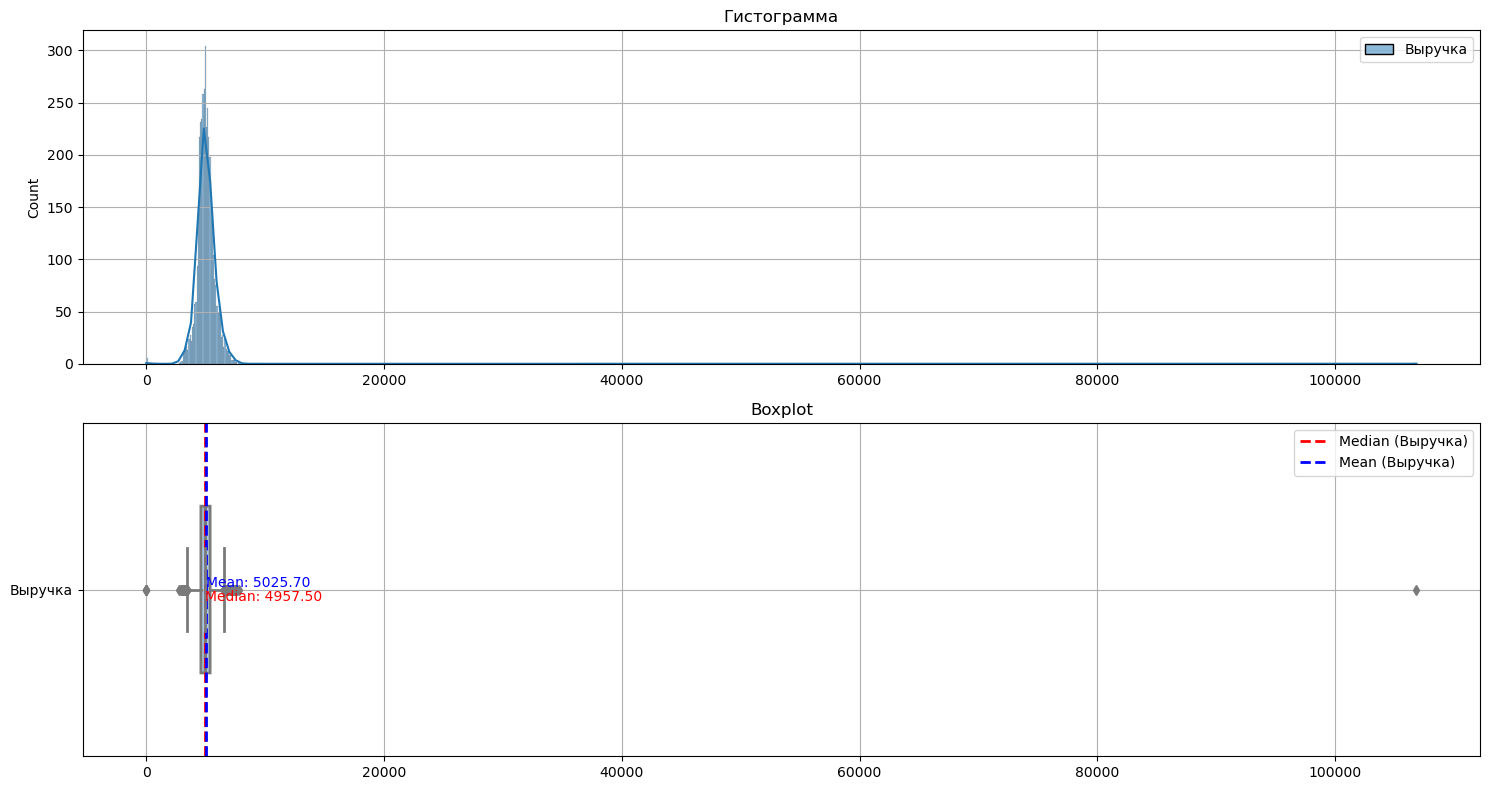

In [58]:
plot_distribution_summary(market_money, "Выручка")

In [59]:
outliers_condition = market_money['Выручка'] > 20_000
market_money.loc[outliers_condition, ['id', 'Период']].iloc[0]

id               215380
Период    текущий_месяц
Name: 98, dtype: object

In [60]:
target_id, target_period = market_money.loc[outliers_condition, ['id', 'Период']].iloc[0]
median_value = market_money.loc[(market_money['id'] == target_id) & (market_money['Период'] != target_period), 'Выручка'].median()

# Заменяем выброс медианным значением
mask_outliers = (market_money['id'] == target_id) & (market_money['Период'] == target_period) & (market_money['Выручка'] > 20_000)
market_money.loc[mask_outliers, 'Выручка'] = median_value

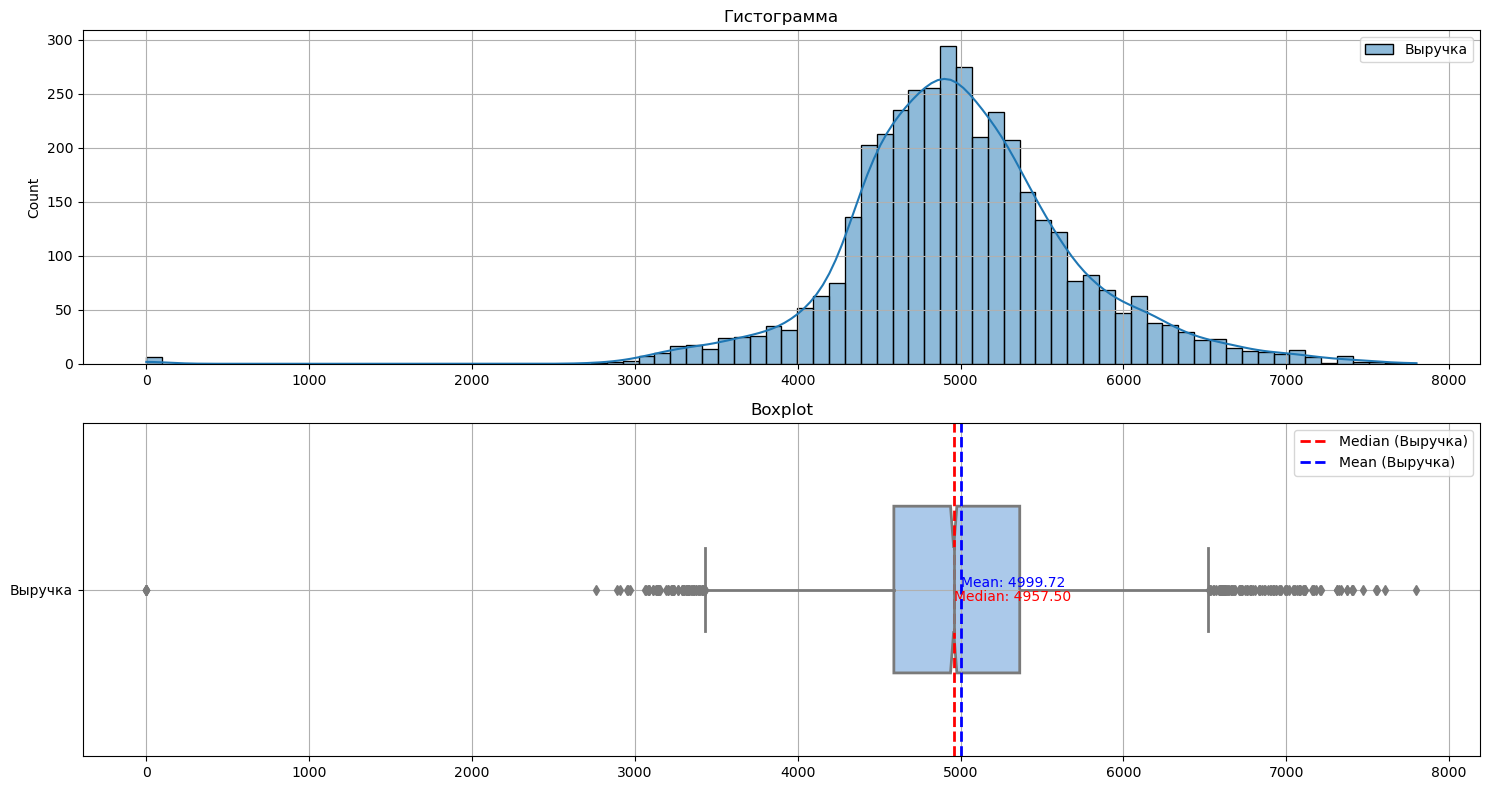

In [61]:
plot_distribution_summary(market_money, "Выручка")

Теперь всё хорошо! Median сохранили и среднее приблизилось к медианному значению

In [62]:
market_money.query("Выручка == 0.0")

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Видим нули за `препредыдущий_месяц`, `предыдущий_месяц`, а за текущий уже имеется выручка. Такие необходимо в будущем удалить

### money

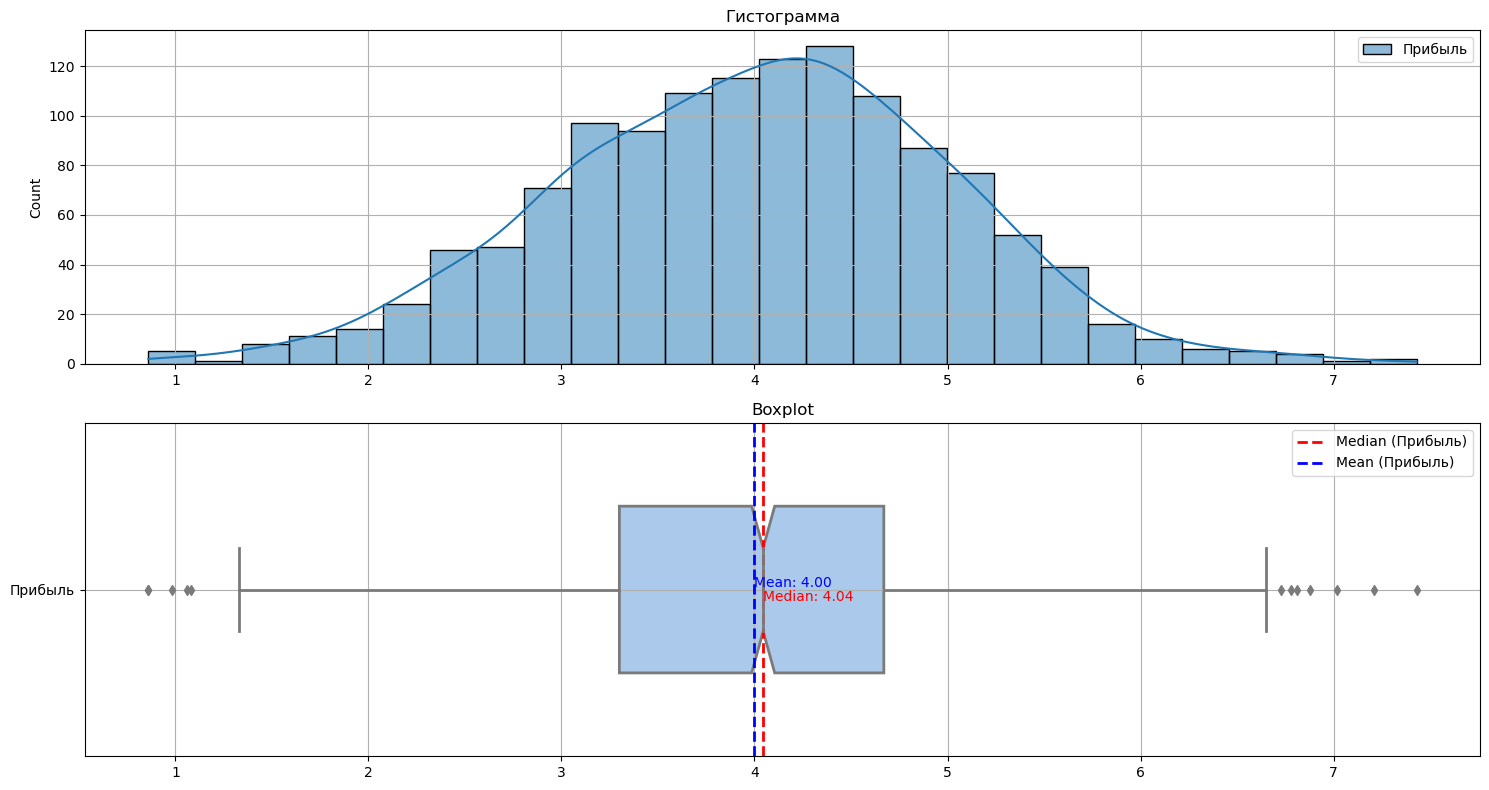

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


In [63]:
money['Прибыль'] = money['Прибыль'].str.replace(',', '.').astype(float)
plot_distribution_summary(money, "Прибыль")
money.describe()

**Вывод:** Данные распредлены нормально имеется незначительное число высоких значений

### market_file

In [64]:
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Видим опечатку в столбце `Тип сервиса`

In [65]:
#Произведем исправление значения

market_file['Тип сервиса'] = market_file['Тип сервиса'].replace({'стандартт': 'стандарт'})

In [66]:
# Проверим результат исправления:

market_file['Тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

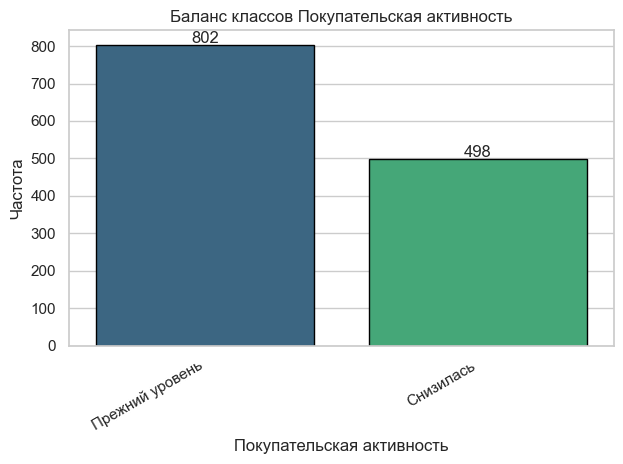

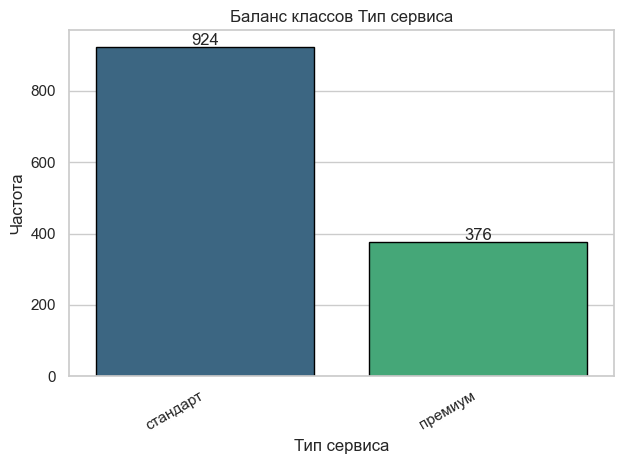

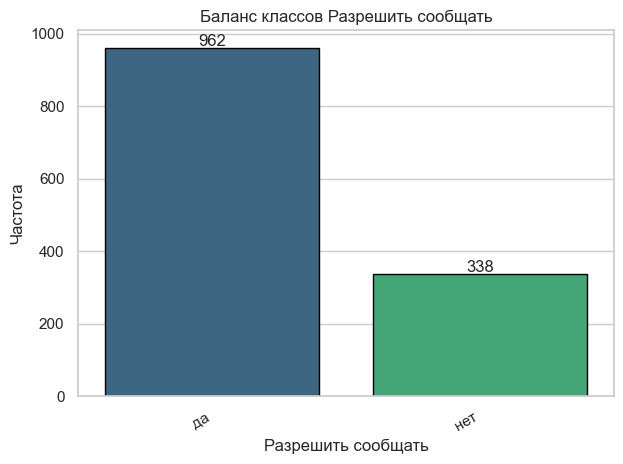

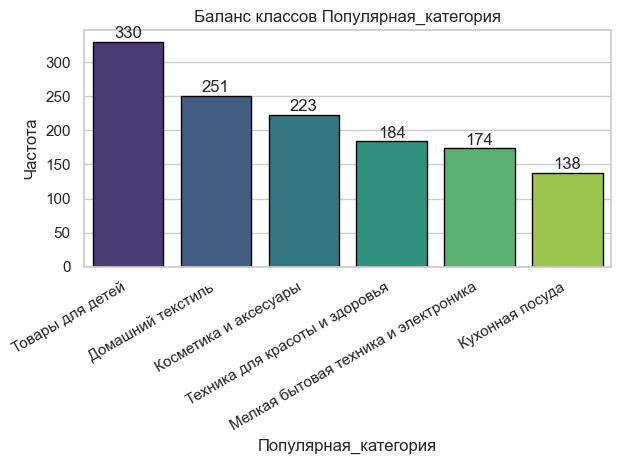

In [67]:
category_columns = ['Покупательская активность', 'Тип сервиса', 'Разрешить сообщать', 'Популярная_категория']
for i in category_columns:
    enhanced_bar_plot(market_file, i, rot=30)

**Вывод:**

1. **Покупательская активность:**
   - Большинство покупателей (802) поддерживают прежний уровень активности.
   - 498 покупателей снизили свою активность.

2. **Тип сервиса:**
   - Стандартный сервис предоставляется 914 покупателям.
   - Премиум-сервис выбрали 376 человек.

3. **Разрешение на получение сообщений:**
   - Большинство покупателей (962) разрешают отправку дополнительных предложений.
   - 338 покупателей отказались от получения дополнительных сообщений.

4. **Популярные категории товаров:**
   - Товары для детей являются самой популярной категорией среди покупателей (330 случаев).
   - Домашний текстиль и Косметика и аксессуары также имеют высокую популярность.
   - Мелкая бытовая техника и электроника, а также Кухонная посуда также привлекают внимание покупателей.

### market_time

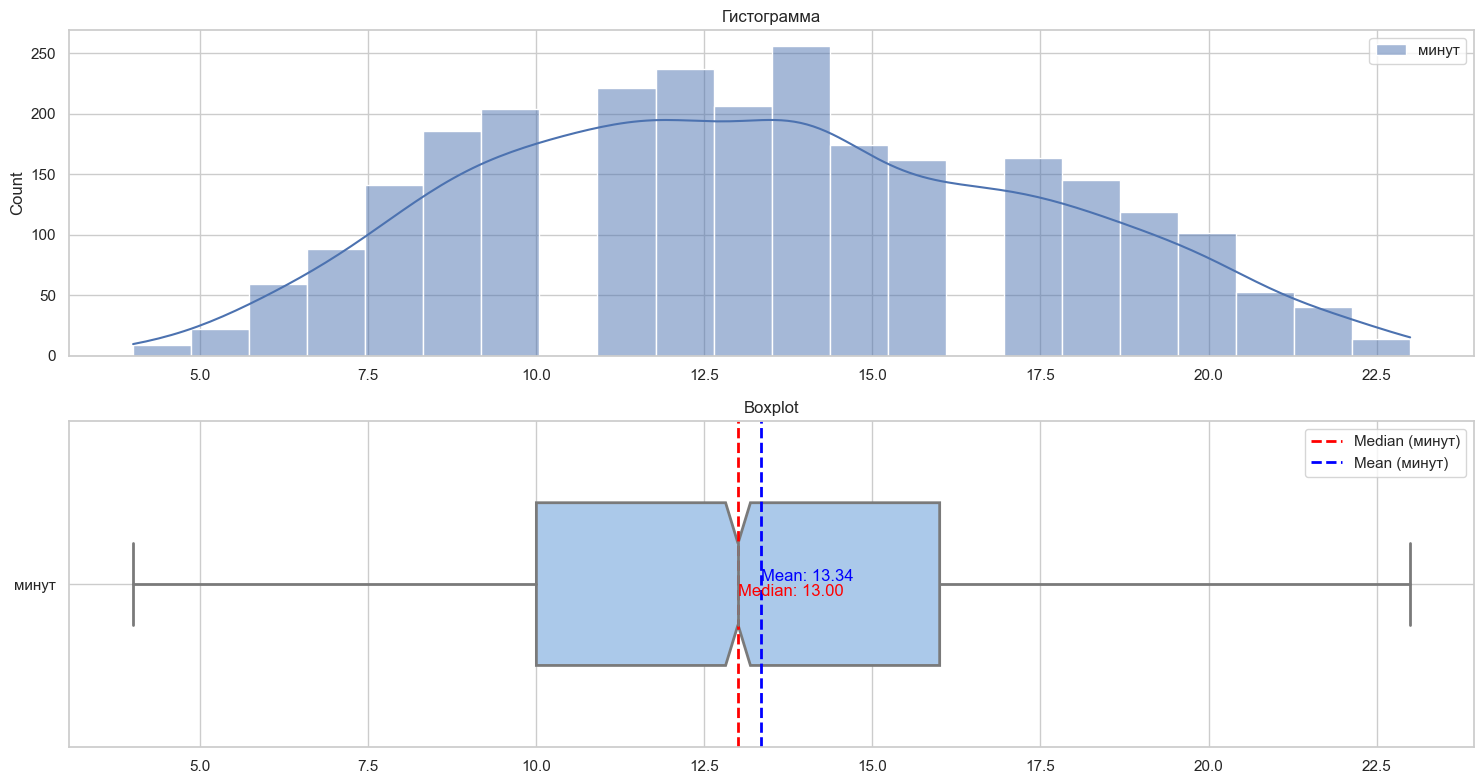

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


In [68]:
plot_distribution_summary(market_time, "минут")
market_time.describe()

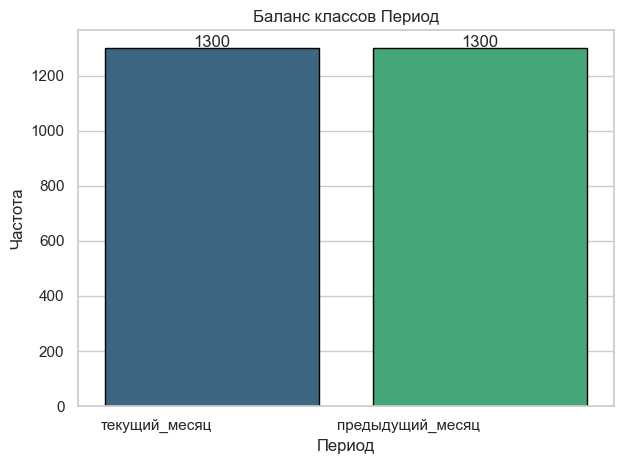

In [69]:
#Подправим опечатку
market_time['Период'] = market_time['Период'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})
enhanced_bar_plot(market_time, "Период")

In [70]:
# удалим нулевые значения

id_zero = market_money.query("Выручка == 0.0")['id'].unique()
market_money = market_money.query("id not in @id_zero")

**Вывод:**
В процессе предобработки данных мы проверили наши данные на наличие пропущенных значений, дубликатов, как явных так и неявных.
В целом можно сказать что данные полученные на входе - не плохие, они не имеют пропущенных значений, в них не было явных дубликатов, а также неявных дубликатов.
Данные имели опечатки в некоторых значениях, которые были замечены и исправлены на этапе предбработки.

В части исследовательсвого анализа мы визуализировали данные и выяснили, что :

**Покупательская активность:**

    Большинство покупателей (802) поддерживают прежний уровень активности.
    498 покупателей снизили свою активность.
    
**Тип сервиса:**

    Стандартный сервис предоставляется 914 покупателям.
    Премиум-сервис выбрали 376 покув данных.
    
**Разрешение на получение сообщений:**

    Большинство покупателей (962) разрешают отправку дополнительных предложений.
    338 покупателей отказались от получения дополнительных сообщений.
    
**Популярные категории товаров:**

    Товары для детей являются самой популярной категорией среди покупателей (330 случаев).
    Домашний текстиль и Косметика и аксессуары также имеют высокую популярность.
    Мелкая бытовая техника и электроника, а также Кухонная посуда также привлекают внипредложения товаров.


# Шаг 3. Объединение таблиц

In [71]:
market_money_ready = market_money.set_index(['id', 'Период'])['Выручка'].unstack()
market_money_ready.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']
print('Market money')
display(market_money_ready.head())

market_time_ready = market_time.set_index(['id', 'Период'])['минут'].unstack()
market_time_ready.columns = ['минут_предыдущий_месяц', 'минут_текущий_месяц']
print('Market time')
display(market_time_ready.head())

Market money


,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц
id,,,
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5
215353,4738.5,5124.0,5388.5


Market time


,минут_предыдущий_месяц,минут_текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [72]:
#Итоговое объеденения
market_file = market_file.set_index('id')
df = market_time_ready.join(market_file)
df = market_money_ready.join(df)
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df.sample(10)

,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
id,,,,,,,,,,,,,,,,,
215403,5824.0,4957.0,6427.2,7,8,Снизилась,премиум,да,1.7,5,771,0.39,Техника для красоты и здоровья,1,8,2,5
216086,4755.5,4667.0,4962.2,16,15,Прежний уровень,стандарт,нет,4.3,3,494,0.25,Косметика и аксесуары,2,3,4,4
216272,4485.0,4978.0,5042.7,8,14,Прежний уровень,стандарт,нет,5.0,4,685,0.26,Товары для детей,3,5,0,8
215949,6057.5,5396.0,6760.8,12,18,Прежний уровень,стандарт,да,3.6,5,928,0.12,Домашний текстиль,6,0,6,8
215507,4464.0,4969.0,4794.2,16,9,Снизилась,стандарт,да,3.8,3,871,0.32,Техника для красоты и здоровья,2,4,6,7
215830,4432.0,5311.0,5323.8,19,8,Снизилась,стандарт,да,5.1,5,185,0.18,Кухонная посуда,4,5,5,14
215824,4950.5,4781.0,5227.4,15,12,Снизилась,стандарт,нет,3.9,5,852,0.21,Косметика и аксесуары,3,0,2,7
216643,3664.0,4704.0,4741.7,14,7,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11
215566,3877.0,4702.0,4191.6,8,14,Снизилась,премиум,да,2.4,4,785,0.24,Товары для детей,3,1,3,6


# Шаг 4. Корреляционный анализ


interval columns not set, guessing: ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'минут_предыдущий_месяц', 'минут_текущий_месяц', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит']


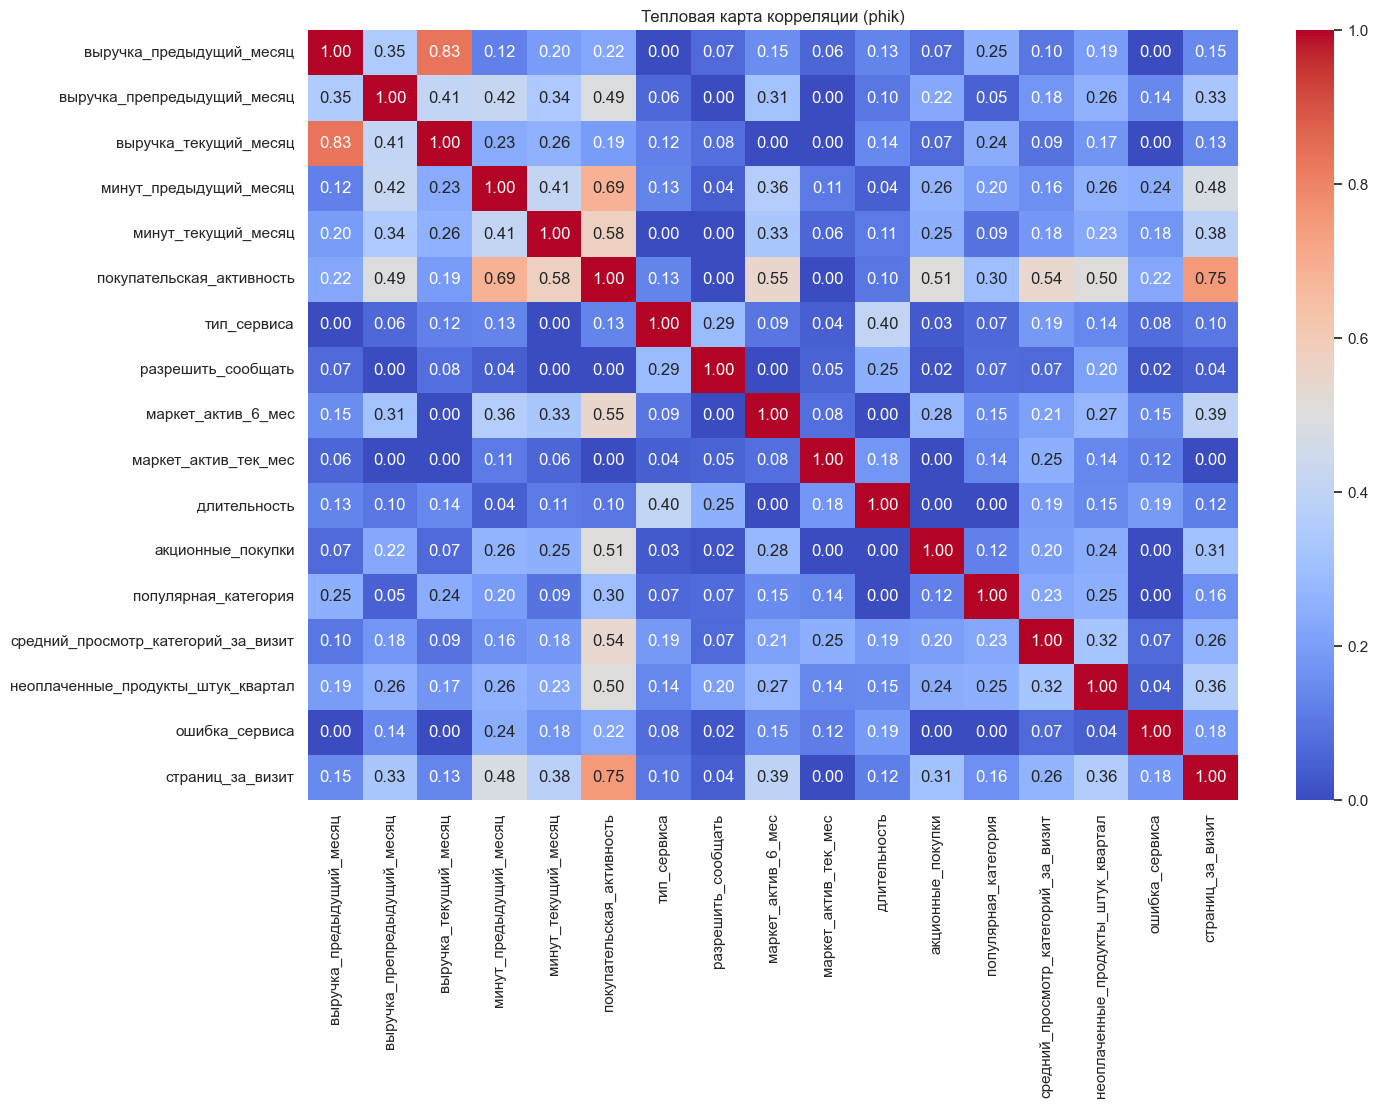

In [73]:
correlation_matrix = df.phik_matrix()


plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта корреляции (phik)')
plt.show()

In [74]:
# Вывод уникальных пар с сильной корреляцией и их силы
strong_corr_threshold = 0.9
strong_corr_pairs = set()

for i, col in enumerate(correlation_matrix.columns):
    correlated_cols = correlation_matrix.index[i+1:][correlation_matrix[col][i+1:] > strong_corr_threshold].tolist()
    for correlated_col in correlated_cols:
        pair = (col, correlated_col)
        correlation_strength = correlation_matrix.at[correlated_col, col]
        strong_corr_pairs.add((pair, correlation_strength))

if strong_corr_pairs:
    print("Пары с сильной корреляцией и их сила:")
    for pair, strength in strong_corr_pairs:
        print(f"{pair}: {strength:.2f}")
else:
    print("Сильной корреляции в датасете не найдено.")

Сильной корреляции в датасете не найдено.


**Как видим сильной корреляции между признакми не наблюдается**

# Шаг 5. Использование пайплайнов


In [75]:
category_to_numeric = {"Снизилась":1,
                      "Прежний уровень":0}

df['покупательская_активность'] = df['покупательская_активность'].replace(category_to_numeric)

In [76]:
feature =  df.drop(columns=['покупательская_активность'], axis=1)
target =  df['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.25, random_state=42, stratify=target)

In [77]:
target.value_counts(normalize=True)*100

0    61.835004
1    38.164996
Name: покупательская_активность, dtype: float64

Из за дисбаланса будем использовать f1 меру вместо точности (accuracy), так как F1-мера учитывает как точность (Precision), так и полноту (Recall) модели, поэтому будет более информативным способом оценки моделей. Это особенно важно, когда один из классов имеет значительно меньше экземпляров, чем другой класс.

In [78]:
numeric_columns = X_train.select_dtypes(exclude=[object]).columns
cactegory_columns = X_train.select_dtypes([object]).columns

In [79]:
strat = StratifiedKFold(n_splits=5)

In [80]:
# Создаём конвейер для предобработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('category', OneHotEncoder(drop='first', handle_unknown="ignore", sparse=False), cactegory_columns),
        ('numeric', StandardScaler(), numeric_columns)
    ],
    remainder='passthrough'
)

# Создаём конвейер для моделей
params_list = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__numeric': [StandardScaler(), MinMaxScaler(), RobustScaler(), "passthrough"]
    },
    {
        'models': [DecisionTreeClassifier(random_state=42)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__category': [OneHotEncoder(drop='first', handle_unknown="ignore", sparse=False),
                                   OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
                                   ce.LeaveOneOutEncoder()]
    },
    {
        'models': [LogisticRegression(random_state=42)],
        'models__C': np.linspace(0.1, 5, 20),
        'preprocessor__numeric': [StandardScaler(), MinMaxScaler(), RobustScaler(), "passthrough"]
    },
    {
        'models': [SVC(kernel='linear', probability=True, random_state=42)],
        'models__C': np.linspace(0.1, 5, 20),
        'preprocessor__numeric': [StandardScaler(), MinMaxScaler(), RobustScaler(), "passthrough"]
    }
]

# Создаём конвейер для поиска лучшей модели
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('models', DecisionTreeClassifier(random_state=42))
])


grid_search = GridSearchCV(pipe, params_list, cv=strat, scoring='f1', n_jobs=-1)

In [81]:
grid_search.fit(X_train, y_train);

In [82]:
print(f"Best score: {grid_search.best_score_:.5f}")
print(f"Best params: {grid_search.best_params_}")

Best score: 0.81832
Best params: {'models': SVC(C=2.936842105263158, kernel='linear', probability=True, random_state=42), 'models__C': 2.936842105263158, 'preprocessor__numeric': 'passthrough'}


#### Тестирование

In [83]:
y_test_pred = grid_search.predict(X_test)
print(f"f1 на тестовой выборке: {f1_score(y_test, y_test_pred):.5f}")

f1 на тестовой выборке: 0.83898


# Шаг 6. Анализ важности признаков


In [84]:
best_model = grid_search.best_estimator_

In [85]:
X_train_preprocess  = best_model.named_steps['preprocessor'].transform(X_train)
X_test_preprocess  = best_model.named_steps['preprocessor'].transform(X_test)
X_test_preprocess = pd.DataFrame(X_test_preprocess, columns=best_model.named_steps['preprocessor'].get_feature_names_out(), index=X_test.index)
X_train_preprocess = pd.DataFrame(X_train_preprocess, columns=best_model.named_steps['preprocessor'].get_feature_names_out(), index=X_train.index)

In [86]:
X_test_preprocess.columns =  [col.replace('category__', 'cat_').replace('numeric__', 'num_') for col in X_test_preprocess.columns]

In [87]:
explainer = shap.Explainer(best_model.named_steps['models'], X_train_preprocess)
shap_values = explainer(X_test_preprocess)

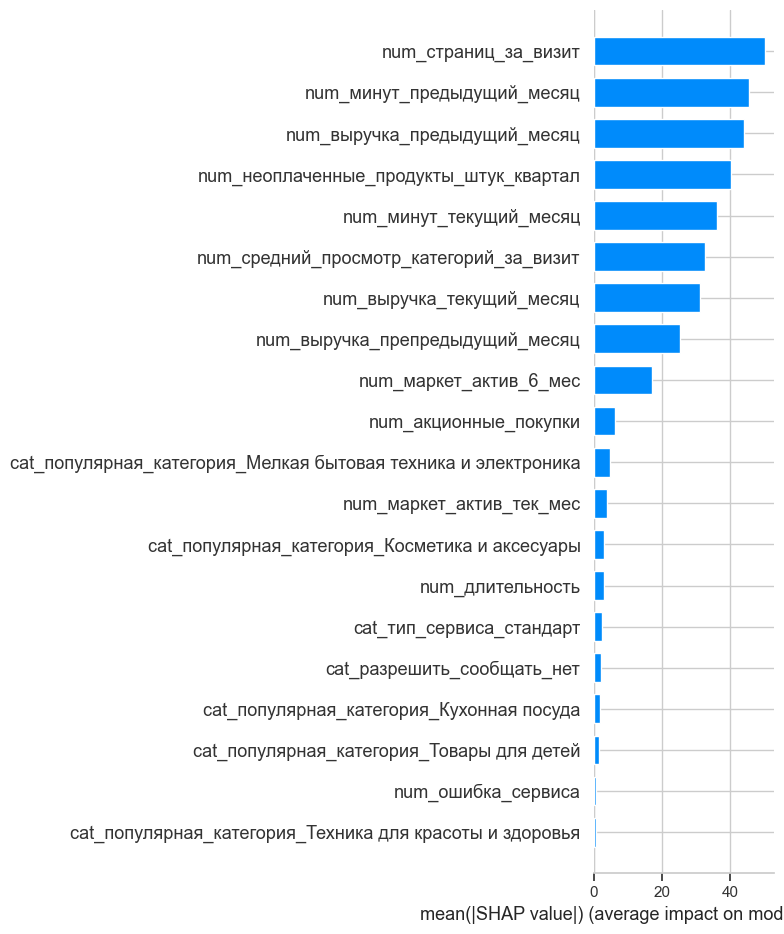

In [88]:
shap.summary_plot(shap_values, X_test_preprocess, plot_type="bar")
plt.show()

Как видим, самые важные признаки оказались , `средний_просмотр_категорий_за_визит`(Показывает, сколько в среднем категорий покупатель просматривает за один визит в течение последнего месяца.)`страниц_за_визит`(Среднее количество страниц, которые просматривает покупатель за один визит на сайт за последние 3 месяца.) и `минут_предыдущий_месяц`(время затраченное пользователем).

# Шаг 7. Сегментация покупателей

Для интернет-магазин «В один клик»  представляет интерес подкатегория пользователей, у которых наблюдается значительная выручка, и существует максимальное вероятное снижение активности в будущем. Такие пользователи могут считаться рискованными с точки зрения удержания, поскольку, несмотря на их текущий вклад в выручку компаниии, существует риск потери активности в будущем. Анализ и выделение этой группы пользователей могут помочь бизнесу принимать целенаправленные меры для их удержания и улучшения взаимоотношений.

In [89]:
segment = pd.DataFrame({'id': X_test.index, 'вероятность_снижения_активности': grid_search.predict_proba(X_test)[:, 1], })
segment = pd.merge(money, segment, on = 'id')
segment.sample(10)

,id,Прибыль,вероятность_снижения_активности
153,215974,3.96,0.023546
79,215650,2.54,0.984665
117,215824,3.66,0.213222
202,216191,5.39,0.253190
251,216356,3.26,0.171231
283,216492,1.68,0.777416
46,215504,2.08,0.960145
103,215762,2.33,0.024722
166,216037,5.23,0.116686
99,215746,3.26,0.296648


#### Рассмотрим  вероятность_снижения_активности

In [90]:
quantiles = segment['вероятность_снижения_активности'].quantile([0.25, 0.5, 0.75])

def assign_segment(profitability):
    if profitability >= quantiles[0.75]:
        return 'высокая_вероятность_снижения'
    elif profitability >= quantiles[0.5]:
        return 'средняя_вероятность_снижения'
    else:
        return 'низкая_вероятность_снижения'

segment['сегмент_вероятность_снижения'] = segment['вероятность_снижения_активности'].apply(assign_segment)
segment.sample(10)

,id,Прибыль,вероятность_снижения_активности,сегмент_вероятность_снижения
22,215411,2.41,0.981586,высокая_вероятность_снижения
96,215727,3.82,0.943699,высокая_вероятность_снижения
163,216016,1.68,0.235614,средняя_вероятность_снижения
18,215397,3.19,0.941568,высокая_вероятность_снижения
241,216335,3.84,0.013112,низкая_вероятность_снижения
161,216007,2.59,0.258380,средняя_вероятность_снижения
183,216097,3.82,0.536902,средняя_вероятность_снижения
239,216322,2.38,0.152895,низкая_вероятность_снижения
277,216473,4.25,0.032184,низкая_вероятность_снижения
93,215715,4.87,0.601442,средняя_вероятность_снижения


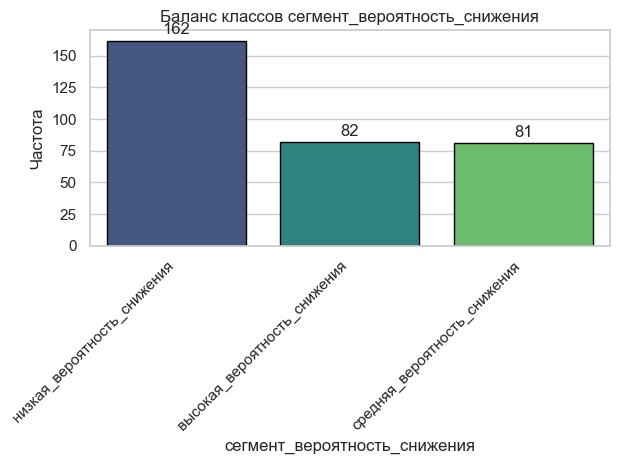

In [91]:
enhanced_bar_plot(segment, "сегмент_вероятность_снижения", rot=45)

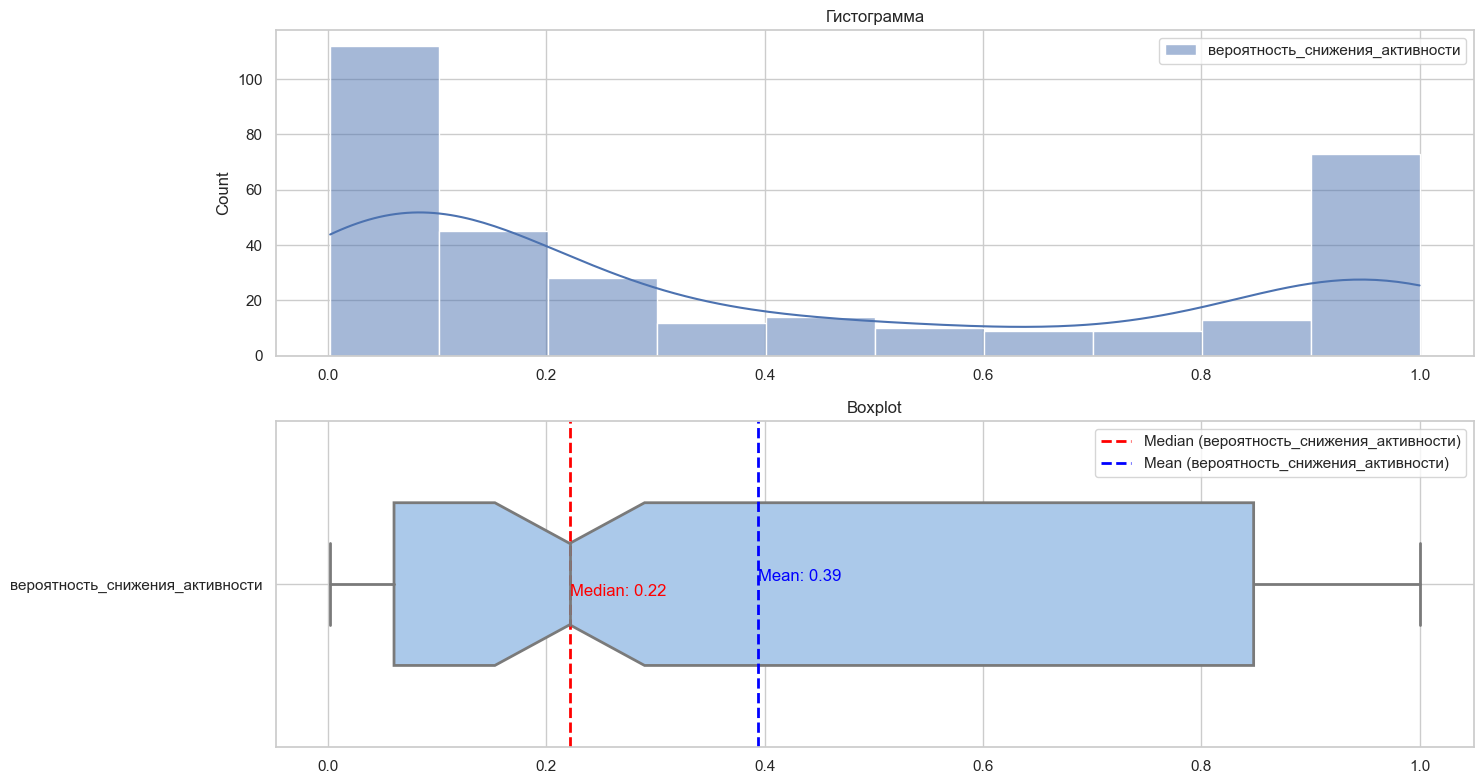

In [92]:
plot_distribution_summary(segment, "вероятность_снижения_активности")

#### Рассмотрим  Прибыль

In [93]:
quantiles_profit = segment['Прибыль'].quantile([0.25, 0.5, 0.75])
def profit_segment(profitability):
    if profitability >= quantiles_profit[0.75]:
        return 'высокая_прибыль'
    elif profitability >= quantiles_profit[0.5]:
        return 'средняя_прибыль'
    else:
        return 'низкая_прибыль'

segment['cегмент_прибыль'] = segment['Прибыль'].apply(profit_segment)

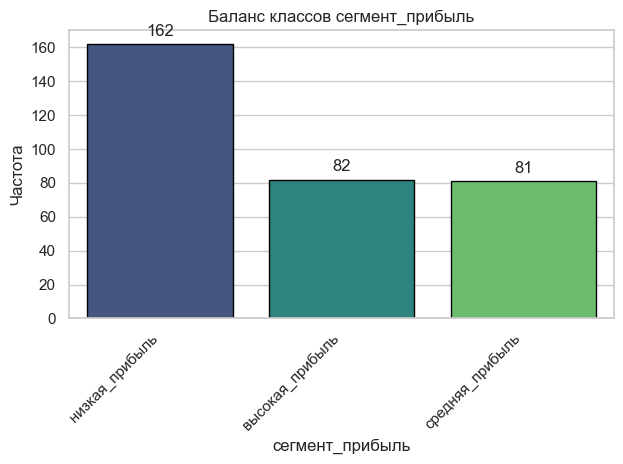

In [94]:
enhanced_bar_plot(segment, "cегмент_прибыль", rot=45)

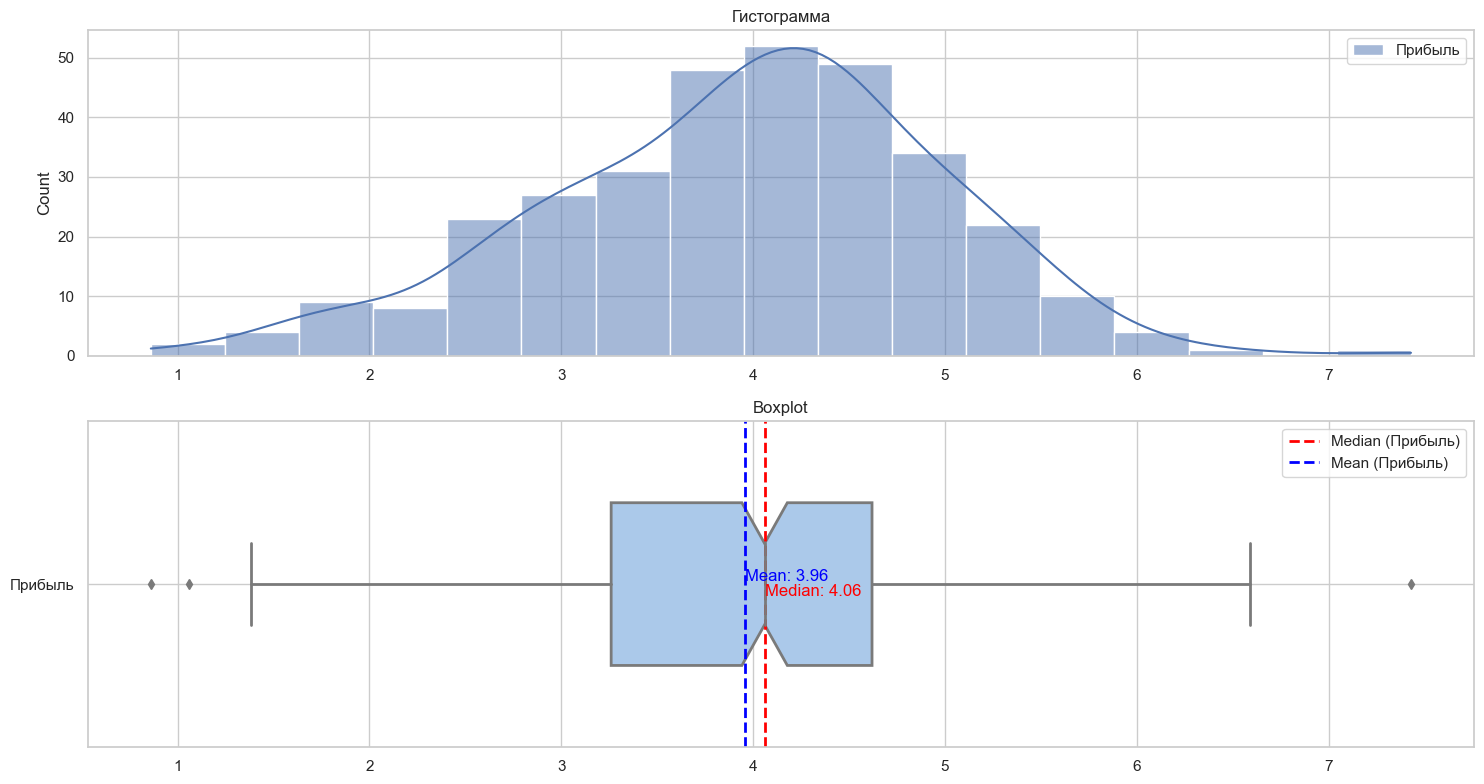

In [95]:
plot_distribution_summary(segment, "Прибыль")

In [96]:
segment = segment.set_index('id')

In [97]:
final_df = pd.merge(segment, df, left_index=True, right_index=True)
final_df.head()

,Прибыль,вероятность_снижения_активности,сегмент_вероятность_снижения,cегмент_прибыль,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,минут_предыдущий_месяц,минут_текущий_месяц,покупательская_активность,...,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
id,,,,,,,,,,,,,,,,,,,,,
215349,4.16,0.904023,высокая_вероятность_снижения,средняя_прибыль,5216.0,4472.0,4971.6,12,10,1,...,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
215351,4.87,0.563514,средняя_вероятность_снижения,высокая_прибыль,6158.0,4793.0,6610.4,11,13,1,...,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
215353,3.95,0.538872,средняя_вероятность_снижения,низкая_прибыль,4738.5,5124.0,5388.5,10,10,1,...,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4
215354,3.62,0.948934,высокая_вероятность_снижения,низкая_прибыль,5685.0,4503.0,5869.6,11,12,1,...,да,5.1,3,431,0.23,Косметика и аксесуары,2,3,7,2
215355,5.26,0.164674,низкая_вероятность_снижения,высокая_прибыль,3263.0,4749.0,3772.6,12,10,1,...,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4


In [98]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325 entries, 215349 to 216645
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Прибыль                              325 non-null    float64
 1   вероятность_снижения_активности      325 non-null    float64
 2   сегмент_вероятность_снижения         325 non-null    object 
 3   cегмент_прибыль                      325 non-null    object 
 4   выручка_предыдущий_месяц             325 non-null    float64
 5   выручка_препредыдущий_месяц          325 non-null    float64
 6   выручка_текущий_месяц                325 non-null    float64
 7   минут_предыдущий_месяц               325 non-null    int64  
 8   минут_текущий_месяц                  325 non-null    int64  
 9   покупательская_активность            325 non-null    int64  
 10  тип_сервиса                          325 non-null    object 
 11  разрешить_сообщать      

Теперь постром boxplot и посмотрим, где у нас просели значения выручки.

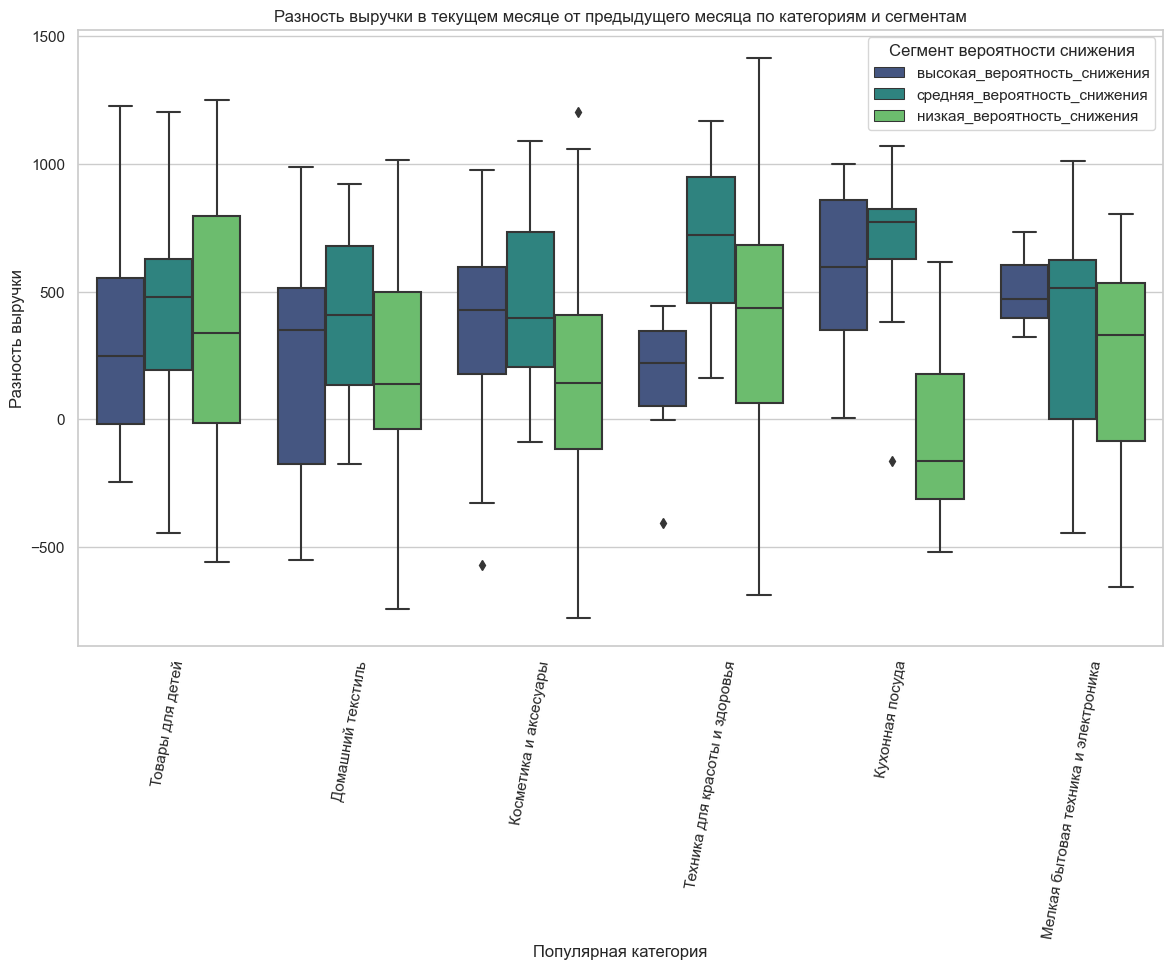

In [99]:
final_df['разность_пре'] = final_df['выручка_текущий_месяц'] - final_df['выручка_предыдущий_месяц']
final_df['разность_препре'] = final_df['выручка_текущий_месяц'] - final_df['выручка_препредыдущий_месяц']


plt.figure(figsize=(14, 8))
ax = sns.boxplot(x='популярная_категория', y='разность_пре', hue='сегмент_вероятность_снижения', data=final_df, palette='viridis')
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
plt.xlabel('Популярная категория')
plt.ylabel('Разность выручки')
plt.title('Разность выручки в текущем месяце от предыдущего месяца по категориям и сегментам')
plt.legend(title='Сегмент вероятности снижения', loc='upper right')
plt.show()

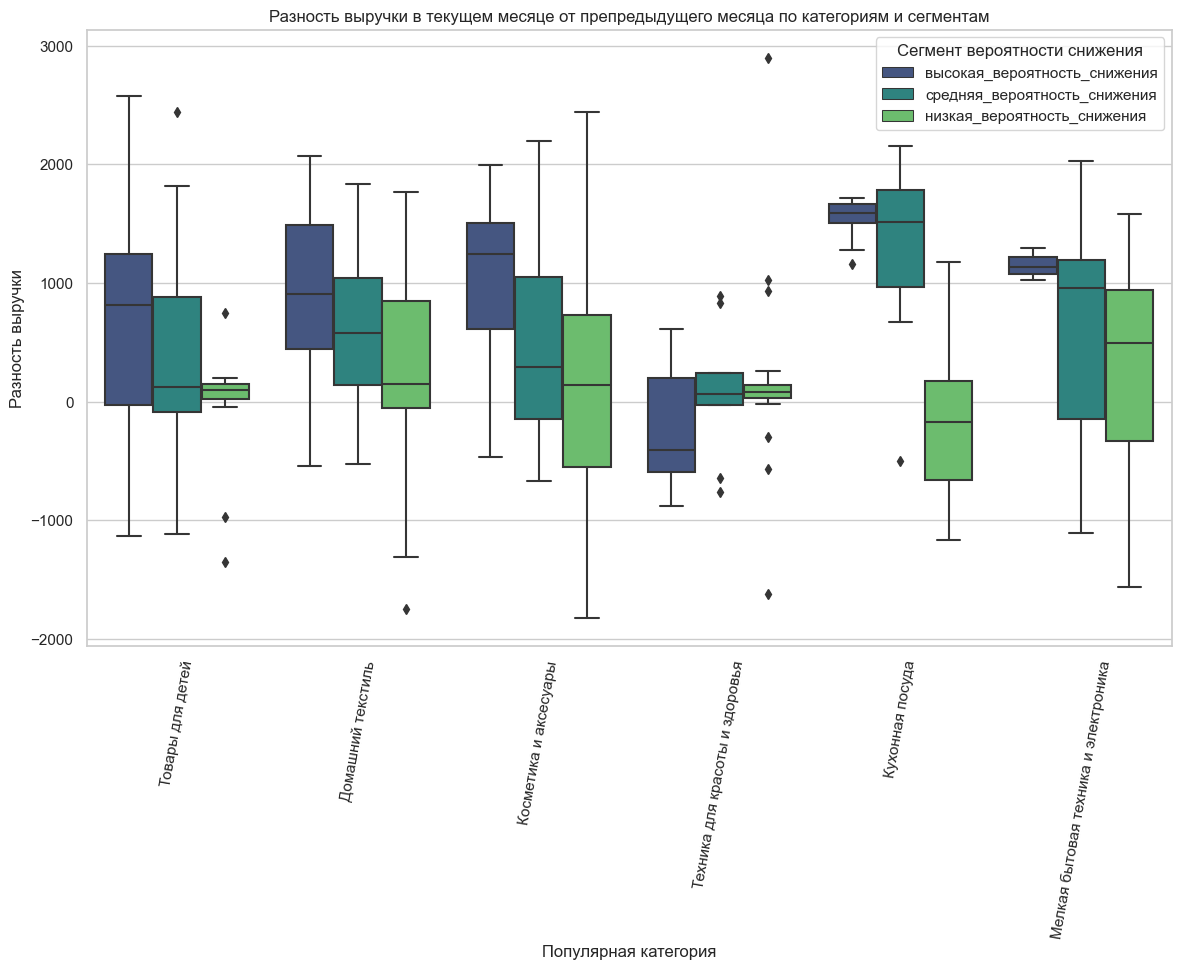

In [100]:
plt.figure(figsize=(14, 8))
ax = sns.boxplot(x='популярная_категория', y='разность_препре', hue='сегмент_вероятность_снижения', data=final_df, palette='viridis')
ax.set_xticklabels(ax.get_xticklabels(), rotation=80)
plt.xlabel('Популярная категория')
plt.ylabel('Разность выручки')
plt.title('Разность выручки в текущем месяце от препредыдущего месяца по категориям и сегментам')
plt.legend(title='Сегмент вероятности снижения', loc='upper right')
plt.show()

Как мы видим, очень сильная просадка по категории `Техника для красоты и здоровья`. У всех остальных категорий разность выручки выше, чем у других сегментов.

Для увеличения покупательской активности в сегменте "Техника для красоты и здоровья" можно предложить следующие стратегии:

1. **Анализ предпочтений и потребностей клиентов:**
   - Провести исследование предпочтений и потребностей целевой аудитории в данной категории.
   - Выделить наиболее востребованные товары и бренды, а также определить факторы, влияющие на решение покупателей.

2. **Продвижение акций и скидок:**
   - Провести маркетинговые акции, предоставляя скидки на товары в данной категории.
   - Создать временные предложения, например, "специальные предложения ...".

3. **Повышение видимости продукции:**
   - Выделить категорию "Техника для красоты и здоровья" на веб-сайте и в рекламных материалах.
   - Создать привлекательные и информативные описания товаров.

4. **Партнерство и сотрудничество:**
   - Рассмотреть возможность партнерства с другими брендами или предоставления дополнительных услуг (например, бесплатные консультации по использованию продукции).

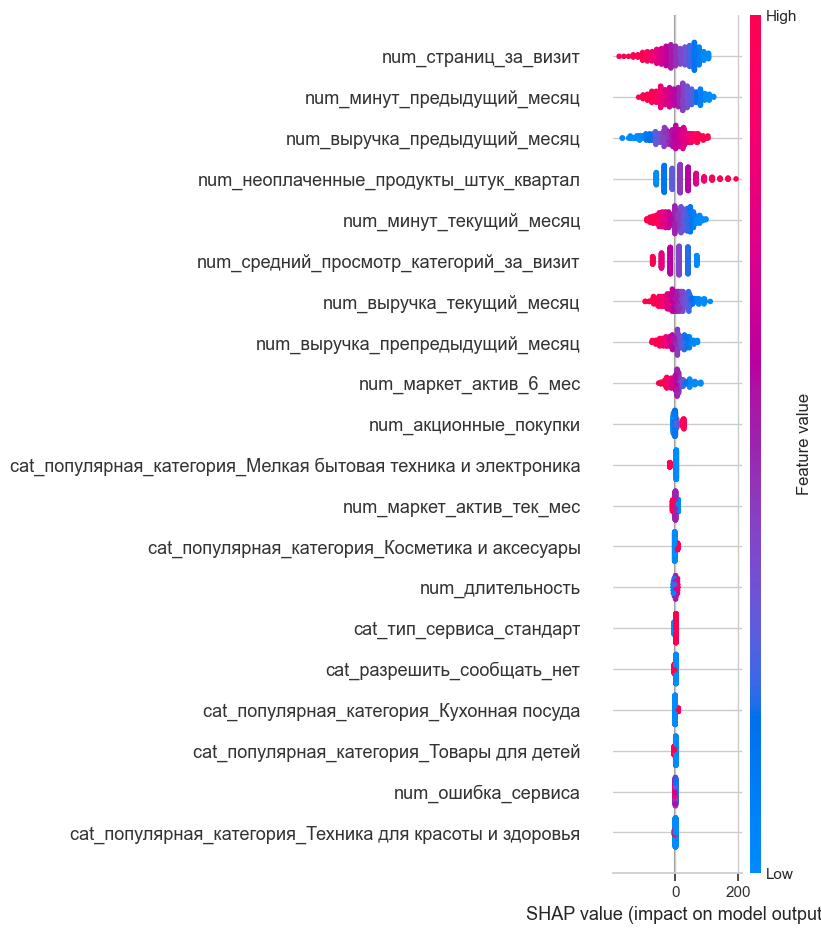

In [101]:
#бонус
shap.summary_plot(shap_values, X_test_preprocess)
plt.show()


1. **Акционные покупки:** Увеличение числа акционных покупок может быть связано с текущим снижением активности. Следовательно, стратегии по сокращению акционных предложений или пересмотру их эффективности могут помочь в стабилизации активности.

2. **Страницы за визит:** Уменьшение числа просмотренных страниц за визит может сигнализировать о снижении интереса. Рекомендуется провести анализ содержания страниц и возможностей улучшения пользовательского опыта для повышения удовлетворенности и увеличения активности.

3. **Минуты предыдущий месяц:** Уменьшение времени, проведенного пользователями в предыдущем месяце, может указывать на потенциальное снижение удовлетворенности сервисом.

4. **Неоплаченные продукты:** Увеличение числа неоплаченных продуктов может свидетельствовать о проблемах в процессе оплаты или недостаточной привлекательности товаров.

5. **Выручка предыдущий месяц:** Уменьшение выручки предыдущего месяца может быть следствием неэффективных маркетинговых стратегий или устаревших предложений.

В случае успешного решения указанных проблем, вероятно, удастся увеличить общую активность пользователей и повысить их участие в предоставляемых услугах.

# Шаг 8. Общий вывод


Онлайн-магазин «В один клик» столкнулся с проблемой оттока покупателей и необходимостью удержания постоянных клиентов для стимулирования их покупательской активности. Чтобы решить данную проблему, перед нами была поставлена задача разработать систему персонализированных предложений для постоянных покупателей с применением анализа данных и построения бизнес-модели.

Для анализа были предоставлены четыре набора данных: market_file.csv, market_money.csv, market_time.csv и money.csv. На этапе предварительной обработки данных и исследовательского анализа были обнаружены и устранены различные ошибки, такие как некорректное написание данных в наборах и наличие аномалий, которые были заменены на медианные значения.

В ходе исследовательского анализа были получены следующие результаты:
Покупательская активность: большинство покупателей (802) поддерживают прежний уровень активности, 498 - снизили активность;
Стандартный сервис предоставлен 914 покупателям, премиум-сервис - 376 покупателям;
Разрешение на отправку сообщений: большинство покупателей (962) дают разрешение на отправку им сообщений, 338 - отказываются от получения сообщений;
Наиболее популярные категории товаров: товары для детей (330 покупок), домашний текстиль и косметика (298 покупок), мелкая бытовая техника и электроника (289 покупок), кухонная посуда (247 покупок).
Анализ корреляционной матрицы не выявил мультиколлинеарности данных.

Также были определены наиболее значимые признаки: `средний_просмотр_категорий_за_визит`(Показывает, сколько в среднем категорий покупатель просматривает за один визит в течение последнего месяца.)`страниц_за_визит`(Среднее количество страниц, которые просматривает покупатель за один визит на сайт за последние 3 месяца.) и `минут_предыдущий_месяц`(время затраченное пользователем).

----

Анализируя более подробно модель с помощью SHAP были сделаны следующие выводы:


1. **Акционные покупки:** Увеличение числа акционных покупок может быть связано с текущим снижением активности. Следовательно, стратегии по сокращению акционных предложений или пересмотру их эффективности могут помочь в стабилизации активности.

2. **Страницы за визит:** Уменьшение числа просмотренных страниц за визит может сигнализировать о снижении интереса. Рекомендуется провести анализ содержания страниц и возможностей улучшения пользовательского опыта для повышения удовлетворенности и увеличения активности.

3. **Минуты предыдущий месяц:** Уменьшение времени, проведенного пользователями в предыдущем месяце, может указывать на потенциальное снижение удовлетворенности сервисом.

4. **Неоплаченные продукты:** Увеличение числа неоплаченных продуктов может свидетельствовать о проблемах в процессе оплаты или недостаточной привлекательности товаров.

5. **Выручка предыдущий месяц:** Уменьшение выручки предыдущего месяца может быть следствием неэффективных маркетинговых стратегий или устаревших предложений.

В случае успешного решения указанных проблем, вероятно, удастся увеличить общую активность пользователей и повысить их участие в предоставляемых услугах.


---

В ходе сегментирования было выявлено, что очень сильная просадка по категории `Техника для красоты и здоровья`. У всех остальных категорий разность выручки выше, чем у других сегментов.

Для увеличения покупательской активности в сегменте "Техника для красоты и здоровья" можно предложить следующие стратегии:

1. **Анализ предпочтений и потребностей клиентов:**
   - Провести исследование предпочтений и потребностей целевой аудитории в данной категории.
   - Выделить наиболее востребованные товары и бренды, а также определить факторы, влияющие на решение покупателей.

2. **Продвижение акций и скидок:**
   - Провести маркетинговые акции, предоставляя скидки на товары в данной категории.
   - Создать временные предложения, например, "специальные предложения ...".

3. **Повышение видимости продукции:**
   - Выделить категорию "Техника для красоты и здоровья" на веб-сайте и в рекламных материалах.
   - Создать привлекательные и информативные описания товаров.

4. **Партнерство и сотрудничество:**
   - Рассмотреть возможность партнерства с другими брендами или предоставления дополнительных услуг (например, бесплатные консультации по использованию продукции).